# Reinforcement Learning Lab: Tic-Tac-Toe with Deep Q-Learning
<img src="../images/tictactoe.png" alt="Tic Tac Toe Example" width="200"/>

**What is this lab about?**  

In this lab, we’ll train an **RL agent** to play **Tic-Tac-Toe** using the **Deep Q-Learning (DQN) algorithm**.  
DQN is a **value-based algorithm** that uses a **neural network** to approximate the Q-function, allowing it to handle larger state spaces efficiently.  

We will focus on:  

- Understanding the **DQN update rule**.  
- Implementing the **neural network agent**.  
- Using a **replay buffer** for experience replay.  
- Training against a random opponent.  
- Visualizing results.  

---

## Table of Contents  

- [1 - Packages](#1)  
- [2 - Tic-Tac-Toe Environment](#2)  
- [3 - DQN Agent (Neural Network)](#3)  
- [4 - Replay Buffer](#4)  
- [5 - Training Loop](#5)  
- [6 - Plotting Results](#6)  
- [7 - Evaluation](#7)  
- [8 - Exercises](#8)  


## 1 - Packages <a id="1"></a>

In this section, we will import all the necessary packages for our Deep Q-Learning Tic-Tac-Toe project.

**Instructions for Students:**

1. **numpy**: For numerical operations and handling the board as arrays.  
2. **random**: To implement exploration strategies like epsilon-greedy.  
3. **collections.deque**: For the replay buffer to store past experiences efficiently.  
4. **matplotlib.pyplot**: To plot training results and visualize learning progress.  
5. **torch**: For building the neural network that approximates Q-values.  
6. **torch.nn, torch.optim**: To define network layers, activation functions, and the optimizer.

**Tip:** Ensure PyTorch is installed. If not, run `!pip install torch` in a notebook cell before starting.


In [1]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim


## 2 - Tic-Tac-Toe Environment <a id="2"></a>

In this section, we will define the **TicTacToe** class to simulate the game environment.

**Instructions for Students:**

1. Implement `reset()` to initialize an empty 3x3 board.  
2. Implement `available_actions()` to return the list of empty positions.  
3. Implement `step(action, player)` to place a move and return `(next_state, reward, done)`.  
4. Implement `check_game(player)` to detect **win, loss, or draw**.  

**Tips:**

- Use a 3x3 NumPy array:  
  - `0` for empty  
  - `1` for the agent  
  - `-1` for the opponent  

- Reward structure suggestion:  
  - `+1` for a win  
  - `0` for a draw  
  - `-1` for a loss  
  - `-10` for an illegal move (optional)

**Illustrative Diagram:**



In [2]:
class TicTacToe:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.done = False
        self.winner = None
        return self.board.flatten()
    
    def available_actions(self):
        return [i for i in range(9) if self.board.flatten()[i] == 0]
    
    def step(self, action, player):
        if self.board.flatten()[action] != 0:
            return self.board.flatten(), -10, True  # Illegal move penalty
        self.board[action // 3, action % 3] = player
        reward, self.done, self.winner = self.check_game(player)
        return self.board.flatten(), reward, self.done
    
    def check_game(self, player):
        # Check rows and columns
        for i in range(3):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return 1, True, player
        # Check diagonals
        if self.board[0, 0] == self.board[1, 1] == self.board[2, 2] == player or \
           self.board[0, 2] == self.board[1, 1] == self.board[2, 0] == player:
            return 1, True, player
        # Check draw
        if np.all(self.board != 0):
            return 0, True, 0  # Draw
        return 0, False, None


## 3 - DQN Agent (Neural Network) <a id="3"></a>

In this section, we will implement a **neural network** to approximate Q-values for each action.

**Instructions for Students:**

1. Input layer: 9 neurons (one for each cell on the Tic-Tac-Toe board).  
2. Hidden layers: 2 fully connected layers with 128 neurons each, using ReLU activation.  
3. Output layer: 9 neurons (Q-value for each possible action).  

**Tips:**

- During training, only choose actions that are valid (empty cells).  
- The network predicts Q-values for **all 9 positions**, but you will mask illegal moves.  

**Illustrative Diagram:**



## 4 - Replay Buffer <a id="4"></a>

Deep Q-Learning uses **experience replay** to improve training stability.

**Instructions for Students:**

1. Implement a `ReplayBuffer` class with a maximum size.  
2. Use `push()` to store experiences in the form `(state, action, reward, next_state, done)`.  
3. Implement `sample(batch_size)` to randomly sample a batch of experiences for training.  

**Tips:**

- Use `collections.deque` to automatically discard old experiences when the buffer is full.  
- Random sampling breaks the correlation between consecutive experiences, which stabilizes learning.  
- Typical buffer size: 10,000–50,000.  
- Typical batch size: 32–128.


## 5 - Training Loop <a id="5"></a>

In this section, we will train the Deep Q-Learning agent using the Tic-Tac-Toe environment.

**Instructions for Students:**

1. Initialize the environment and the DQN network.  
2. Implement **epsilon-greedy** action selection:
   - With probability ε, choose a random action (exploration).  
   - With probability 1-ε, choose the action with the highest predicted Q-value (exploitation).  
3. Store experiences `(state, action, reward, next_state, done)` in the replay buffer.  
4. Sample a random batch from the replay buffer and perform the **Q-learning update**:
   - Compute `Q_target = reward + gamma * max(Q(next_state)) * (1 - done)`.  
   - Minimize the mean squared error between `Q(state, action)` and `Q_target`.  
5. Gradually **decay epsilon** to reduce exploration over time.  

**Tips:**

- Typical learning rate: 0.001  
- Discount factor (gamma): 0.99  
- Train for several hundred to a few thousand episodes.  
- Print intermediate results every 50 episodes to monitor progress.


In [6]:
def train_dqn(env, episodes=1000, batch_size=64, gamma=0.99, lr=0.001,
              epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    
    state_size = 9
    action_size = 9
    model = DQN(state_size, action_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    replay_buffer = ReplayBuffer()
    
    epsilon = epsilon_start
    all_rewards = []
    
    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.choice(env.available_actions())
            else:
                with torch.no_grad():
                    q_values = model(torch.FloatTensor(state))
                    action = int(torch.argmax(q_values).item())
                    if action not in env.available_actions():
                        action = random.choice(env.available_actions())
            
            # Take action
            next_state, reward, done = env.step(action, player=1)
            
            # Store experience
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            # Training step
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                
                states = torch.FloatTensor(states)
                next_states = torch.FloatTensor(next_states)
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards)
                dones = torch.FloatTensor(dones)
                
                q_values = model(states).gather(1, actions)
                with torch.no_grad():
                    q_next = model(next_states).max(1)[0]
                    q_target = rewards + gamma * q_next * (1 - dones)
                
                loss = criterion(q_values.squeeze(), q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        all_rewards.append(total_reward)
        
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}/{episodes}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")
    
    return model, all_rewards


## 6 - Plotting Results <a id="6"></a>

After training the DQN agent, it is important to **visualize the learning progress**.

**Instructions for Students:**

1. Plot the **total reward per episode** to see how the agent improves over time.  
2. Observe the trend:
   - Increasing rewards indicate learning.  
   - Flat or fluctuating rewards may indicate unstable learning.  
3. You can also use **moving averages** to smooth the curve for better visualization.

**Tip:** Use `matplotlib.pyplot` for plotting.


In [7]:
def plot_rewards(all_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(all_rewards, label='Episode Reward')
    # Optional: Moving average for smoothing
    window = 50
    if len(all_rewards) >= window:
        moving_avg = np.convolve(all_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(all_rewards)), moving_avg, label=f'{window}-Episode Moving Avg', color='red')
    
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Rewards Over Episodes')
    plt.legend()
    plt.show()


Episode 50/1000, Reward: 1, Epsilon: 0.78
Episode 100/1000, Reward: 1, Epsilon: 0.61
Episode 150/1000, Reward: 1, Epsilon: 0.47
Episode 200/1000, Reward: 1, Epsilon: 0.37
Episode 250/1000, Reward: 1, Epsilon: 0.29
Episode 300/1000, Reward: 1, Epsilon: 0.22
Episode 350/1000, Reward: 1, Epsilon: 0.17
Episode 400/1000, Reward: 1, Epsilon: 0.13
Episode 450/1000, Reward: 1, Epsilon: 0.10
Episode 500/1000, Reward: 1, Epsilon: 0.08
Episode 550/1000, Reward: 1, Epsilon: 0.06
Episode 600/1000, Reward: 1, Epsilon: 0.05
Episode 650/1000, Reward: 1, Epsilon: 0.04
Episode 700/1000, Reward: 1, Epsilon: 0.03
Episode 750/1000, Reward: 1, Epsilon: 0.02
Episode 800/1000, Reward: 1, Epsilon: 0.02
Episode 850/1000, Reward: 1, Epsilon: 0.01
Episode 900/1000, Reward: 1, Epsilon: 0.01
Episode 950/1000, Reward: 1, Epsilon: 0.01
Episode 1000/1000, Reward: 1, Epsilon: 0.01


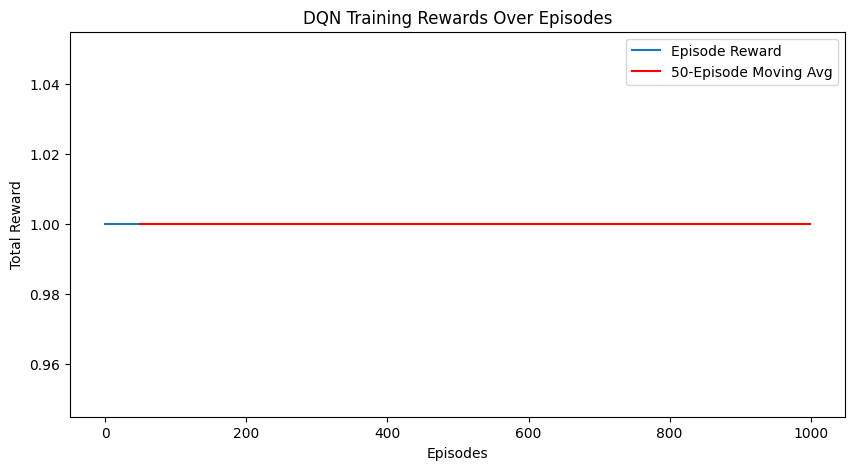

In [8]:
# Train the DQN agent
env = TicTacToe()
model, all_rewards = train_dqn(env, episodes=1000)

# Plot the training results
plot_rewards(all_rewards)


## 7 - Evaluation <a id="7"></a>

After training, we need to **evaluate the agent's performance** by letting it play several games.

**Instructions for Students:**

1. Reset the Tic-Tac-Toe environment at the start of each game.  
2. Let the agent choose the best action (greedy) at each turn.  
3. The opponent can play randomly.  
4. Track the number of **wins, draws, and losses**.  
5. Print the final statistics after all evaluation games.  

**Tip:** Only choose valid moves for both the agent and opponent.


In [9]:
def evaluate(env, model, episodes=100):
    wins, draws, losses = 0, 0, 0
    
    for _ in range(episodes):
        state = env.reset()
        done = False
        
        while not done:
            # Agent chooses action greedily
            with torch.no_grad():
                q_values = model(torch.FloatTensor(state))
                action = int(torch.argmax(q_values).item())
                if action not in env.available_actions():
                    action = random.choice(env.available_actions())
            
            state, reward, done = env.step(action, player=1)
            
            # Opponent random move if game not finished
            if not done:
                opp_action = random.choice(env.available_actions())
                state, reward, done = env.step(opp_action, player=-1)
        
        # Track results
        if reward == 1:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1
    
    print(f"Wins: {wins}, Draws: {draws}, Losses: {losses}")


In [10]:
# Evaluate the trained agent
evaluate(env, model, episodes=100)


Wins: 89, Draws: 11, Losses: 0


## 8 - Exercises <a id="8"></a>

To deepen your understanding of Deep Q-Learning and reinforce your skills, try the following exercises:

1. **Modify the Neural Network Architecture**
   - Change the number of hidden layers or neurons.
   - Observe how it affects learning speed and stability.

2. **Implement a Target Network**
   - Use a separate target network for more stable Q-value updates.
   - Update the target network periodically instead of every step.

3. **Train Against a Smarter Opponent**
   - Replace the random opponent with a rule-based or heuristic agent.
   - Analyze how this affects agent learning.

4. **Visualize Q-Values**
   - Print the Q-values predicted by the network for specific board states.
   - Observe which moves the agent prefers in different situations.

5. **Hyperparameter Tuning**
   - Experiment with learning rate, gamma, epsilon decay, batch size, or replay buffer size.
   - See how these parameters influence training performance.

6. **Add Move Penalties**
   - Penalize illegal moves more heavily or reward quicker wins.
   - Observe changes in agent behavior.

7. **Plot Additional Metrics**
   - Track the number of wins per 50 episodes or moving average reward.
   - Compare different trainin
